# Load the dataset

In [1]:
base_path = 'data'  # base path of where the kitti dataset is stored
from datasets.kitti import create_kitti_dataloaders

# Load the data
train_loader, val_loader, test_loader = create_kitti_dataloaders(
    base_path=base_path,
    batch_size=8,
    num_workers=4
)

In [2]:
# Get a batch of data
images, masks = next(iter(train_loader))

# Print image and mask size
print(f"Image size: {images.size()}")
print(f"Mask size: {masks.size()}")

Image size: torch.Size([8, 3, 256, 256])
Mask size: torch.Size([8, 256, 256])


In [3]:
import matplotlib.pyplot as plt
import numpy as np

KITTI_CLASSES = {
    0: 'Background',
    1: 'Car',
    2: 'Van',
    3: 'Truck',
    4: 'Pedestrian',
    5: 'Person_sitting',
    6: 'Cyclist',
    7: 'Tram',
    8: 'Misc',
    9: 'DontCare'
}

# Define a color palette for each class (in RGB format)
COLOR_PALETTE = {
    0: (0, 0, 0),        # Background: Black
    1: (255, 0, 0),      # Car: Red
    2: (255, 255, 0),    # Van: Yellow
    3: (255, 255, 255),  # Truck: White
    4: (0, 255, 255),    # Pedestrian: Cyan
    5: (0, 255, 0),      # Person_sitting: Green
    6: (0, 128, 255),    # Cyclist: Light Blue
    7: (128, 0, 0),      # Tram: Dark Red
    8: (128, 128, 128),  # Misc: Gray
    9: (255, 128, 0)     # DontCare: Orange
}

# Function to create a colormap legend
def plot_colormap_legend():
    fig, ax = plt.subplots(figsize=(10, 2))
    for idx, (class_id, class_name) in enumerate(KITTI_CLASSES.items()):
        color = [x/255 for x in COLOR_PALETTE[class_id]]  # Convert RGB to matplotlib format
        ax.add_patch(plt.Rectangle((idx, 0), 1, 1, facecolor=color))
        ax.text(idx + 0.5, -0.1, class_name, ha='center', va='top', rotation=45)
    ax.set_xlim(0, len(KITTI_CLASSES))
    ax.set_ylim(-0.5, 1.5)
    ax.axis('off')
    plt.title('KITTI Classes Color Map')
    plt.tight_layout()
    plt.show()


# Function to plot images and masks
def plot_images_and_masks(images, masks, n_samples=4):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
    for i in range(n_samples):
        # Plot image
        img = images[i].permute(1, 2, 0).numpy()
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title('Image')

        # Plot mask
        mask = masks[i].numpy()
        axes[1, i].imshow(mask, cmap='tab20')
        axes[1, i].axis('off')
        axes[1, i].set_title('Mask')

    plt.tight_layout()
    plt.show()

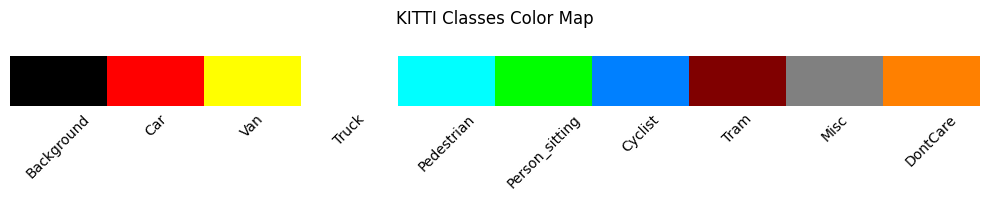

In [4]:
plot_colormap_legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


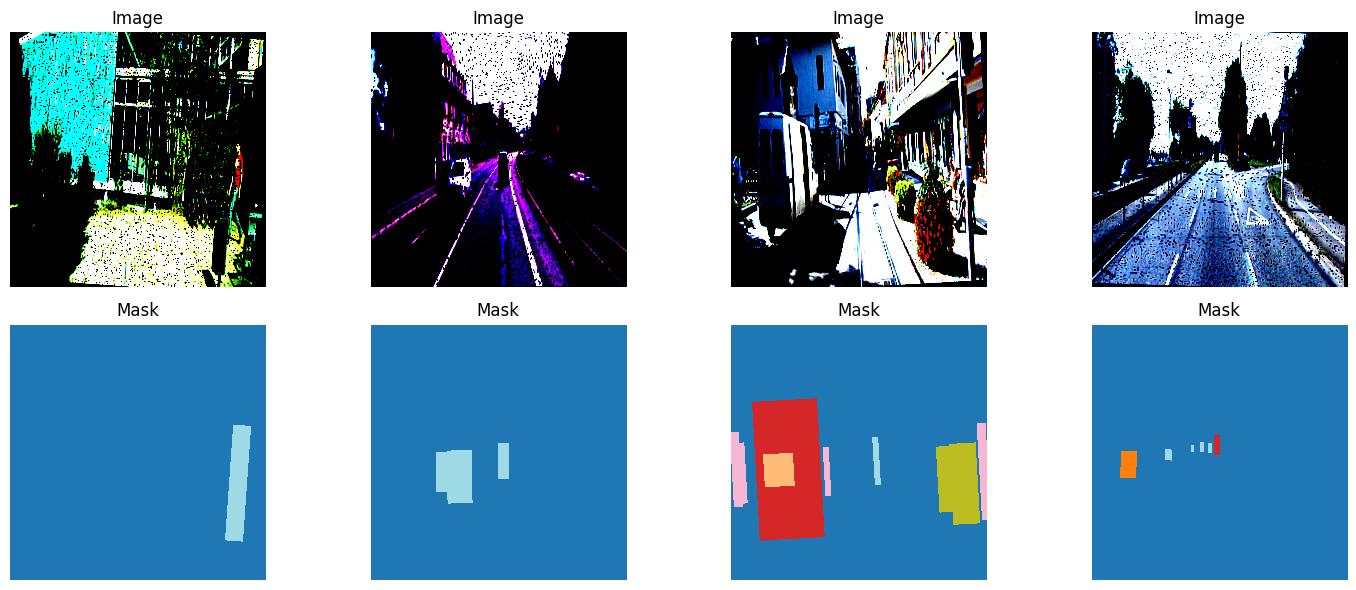

In [5]:
plot_images_and_masks(images, masks)

In [4]:
# https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopping:
    """Early stopping callback similar to Keras implementation"""
    def __init__(
        self,
        monitor='val_loss',
        min_delta=0.0,
        patience=5,
        verbose=1,
        mode='min',
        restore_best_weights=True
    ):
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.mode = mode
        self.restore_best_weights = restore_best_weights

        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.best = float('inf') if mode == 'min' else float('-inf')

    def __call__(self, epoch, model, current):
        if self.mode == 'min':
            improved = current < (self.best - self.min_delta)
        else:
            improved = current > (self.best + self.min_delta)

        if improved:
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if self.verbose > 0:
                    print(f'Early stopping triggered at epoch {epoch}')
                if self.restore_best_weights and self.best_weights is not None:
                    if self.verbose > 0:
                        print('Restoring best weights')
                    model.load_state_dict(self.best_weights)
                return True
        return False


In [6]:
import torch
from unet import UNet
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
from train import train_one_epoch, validate

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_val_iou = 0
patience = 5
patience_counter = 0
delta = 0.003
num_epochs = 2

# Initialize model, criterion, optimizer, and scheduler
model = UNet(n_channels=3, n_classes=10).to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,  # reduce LR by 90% when triggered
        patience=patience,   # number of epochs with no improvement after which LR will be reduced
        min_lr=1e-6  # minimum LR value
        )
# Early stopping parameters
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=delta,
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_iou': [],
    'learning_rates': []
}

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training phase
    model.train()
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, 10)

    # Validation phase
    model.eval()
    val_loss, val_metrics = validate(model, val_loader, criterion, device, 10)

    # Update learning rate
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_metrics['iou'])
    history['learning_rates'].append(current_lr)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val IoU: {val_metrics['iou']:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")

    # Check early stopping
    if early_stopping(epoch, model, val_loss):
        print(f"\nTraining stopped early at epoch {epoch+1}")
        break

# Save the final model and history
torch.save(model.state_dict(), 'kitti_CE_best_model.pth')
import json
with open('kitti_CE_training_history.json', 'w') as f:
    json.dump(history, f)


Epoch 1/2


 16%|█▌        | 103/655 [00:43<03:46,  2.44it/s, loss=1.47]

100%|██████████| 655/655 [04:31<00:00,  2.42it/s, loss=0.491]


Train Loss: 1.0296
Val Loss: 0.5793
Val IoU: 0.1247
Learning Rate: 0.000100

Epoch 2/2


100%|██████████| 655/655 [04:31<00:00,  2.42it/s, loss=0.22] 


Train Loss: 0.4274
Val Loss: 0.3152
Val IoU: 0.1479
Learning Rate: 0.000100


In [14]:
# val_metrics

{'dice': 0.17258955538272858,
 'iou': 0.15489241480827332,
 'precision': 0.17163802683353424,
 'recall': 0.17365369200706482,
 'f1_score': 0.17258954048156738,
 'confusion_matrix': array([[64318640,   647107,        0,        0,        0,        0,
                0,        0,        0,        0],
        [ 1507332,  4438694,        0,        0,        0,        0,
                0,        0,        0,        0],
        [  471388,   404649,        0,        0,        0,        0,
                0,        0,        0,        0],
        [  244899,    65086,        0,        0,        0,        0,
                0,        0,        0,        0],
        [  420487,    31442,        0,        0,        0,        0,
                0,        0,        0,        0],
        [    7821,     3801,        0,        0,        0,        0,
                0,        0,        0,        0],
        [  160321,    30022,        0,        0,        0,        0,
                0,        0,        0

/tmp/ipykernel_27739/1549900035.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('kitti_CE_best_model.pth'))


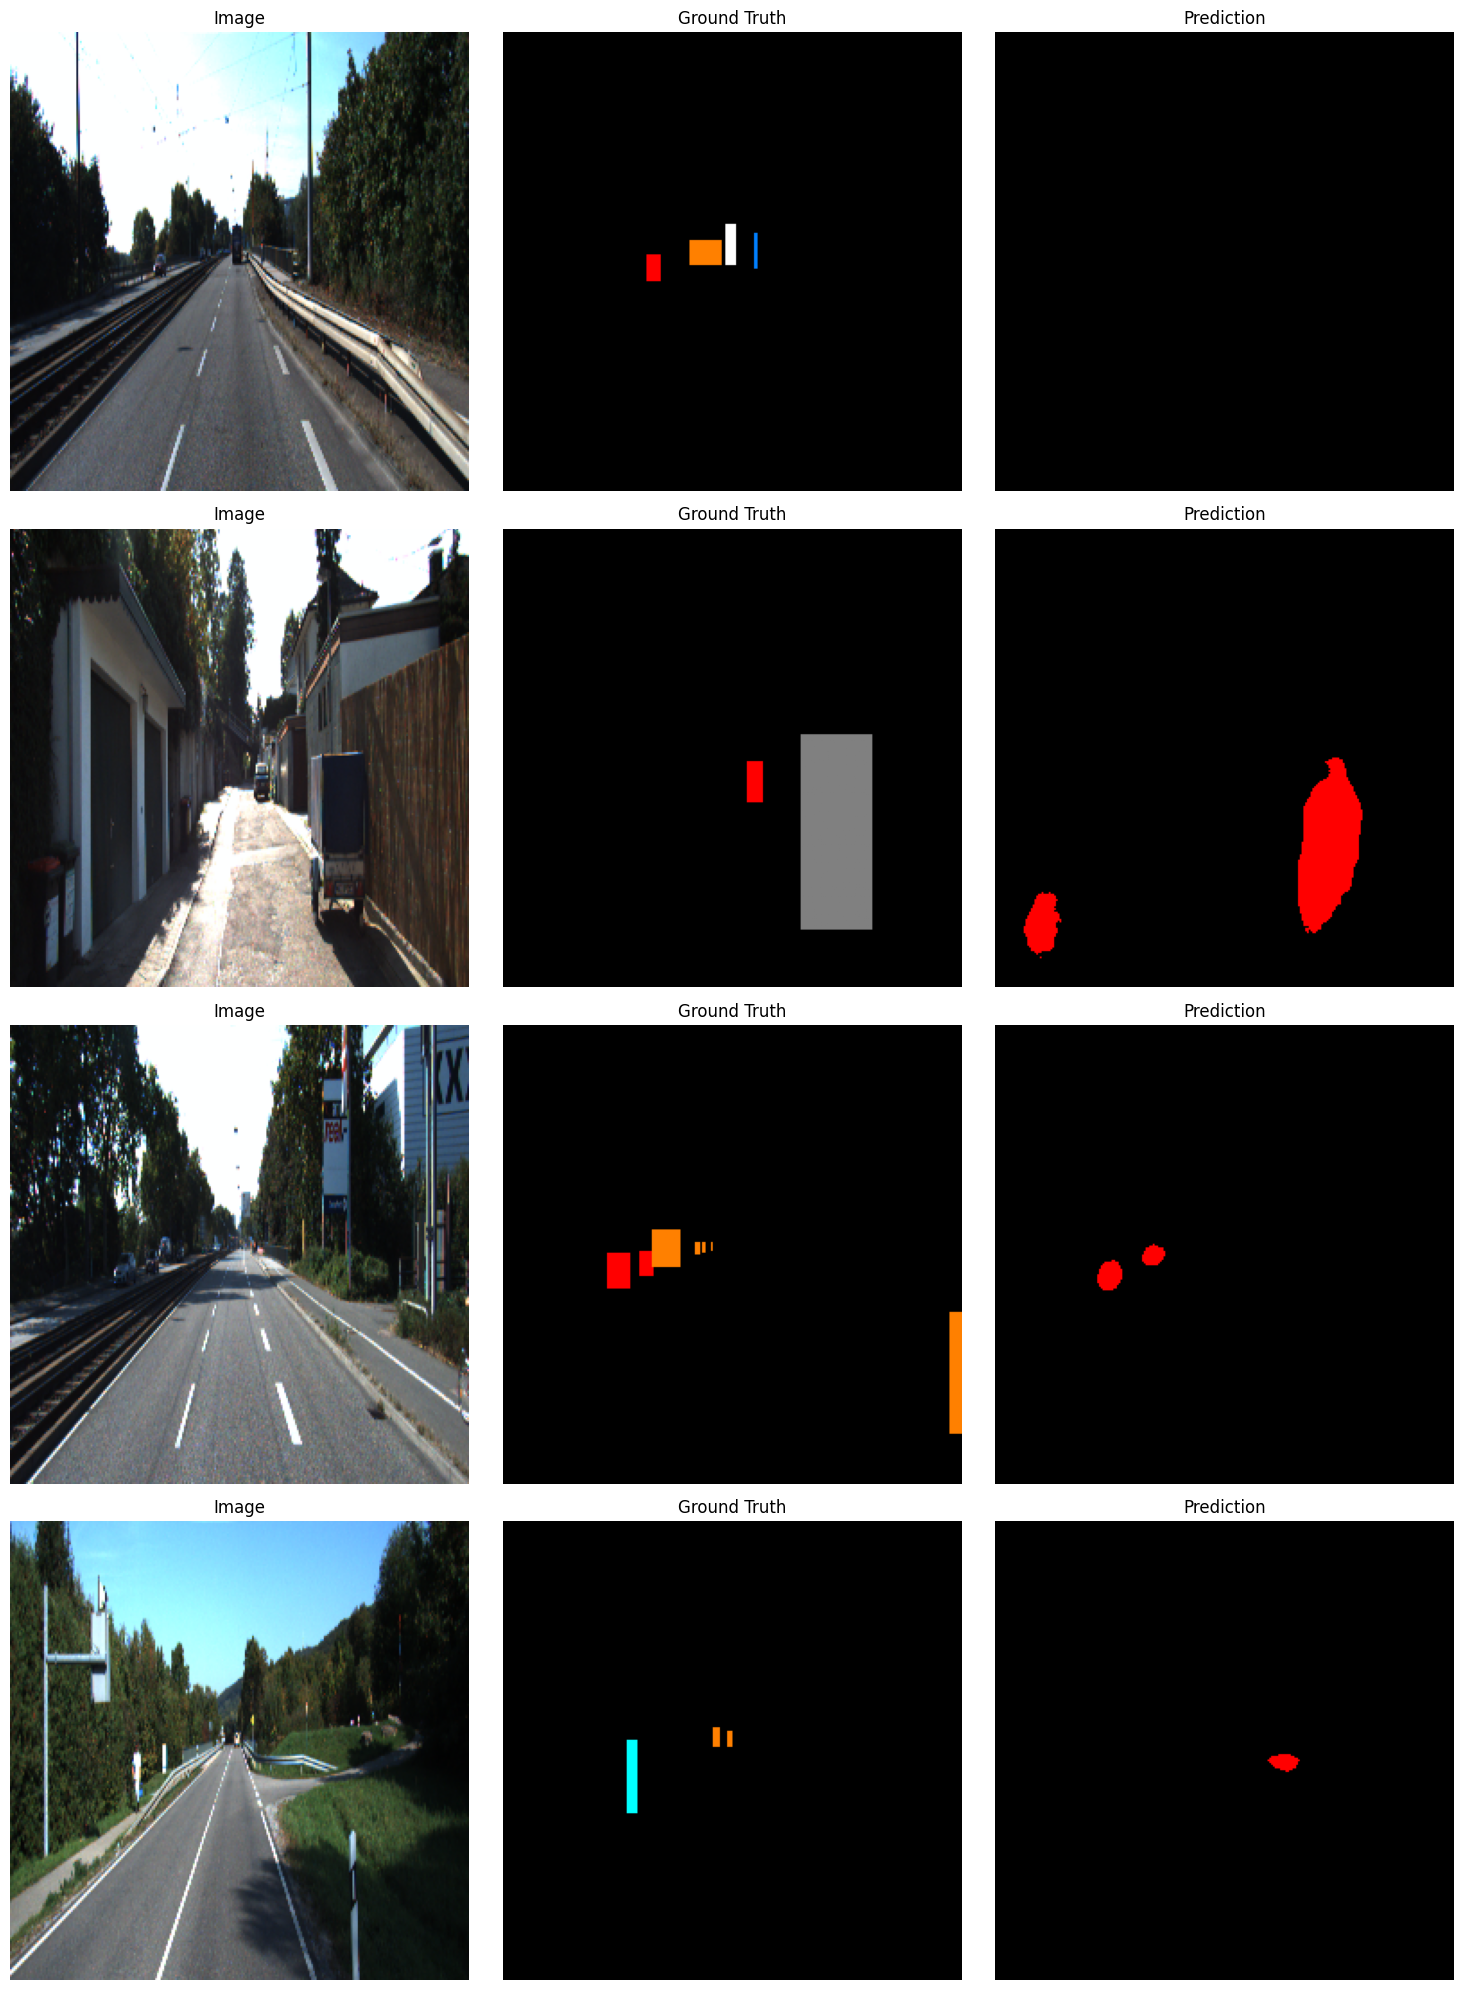


Test Set Metrics:
Loss: 0.3099
IoU: 0.1543
Dice Score: 0.1721
Precision: 0.1709
Recall: 0.1735
F1 Score: 0.1721

Per-class IoU scores:
Background: 0.9393
Car: 0.6034
Van: 0.0000
Truck: 0.0000
Pedestrian: 0.0000
Person_sitting: 0.0000
Cyclist: 0.0000
Tram: 0.0000
Misc: 0.0000
DontCare: 0.0000


In [7]:
# Load the best model
loaded_model = UNet(n_channels=3, n_classes=10).to(device)
loaded_model.load_state_dict(torch.load('kitti_CE_best_model.pth'))
loaded_model.eval()

def plot_predictions(images, masks, predictions, n_samples=4):
    """
    Plot images, ground truth masks, and predicted masks side by side
    Args:
        images: Tensor of shape (B, C, H, W)
        masks: Tensor of shape (B, H, W)
        predictions: Tensor of shape (B, C, H, W)
        n_samples: Number of samples to display
    """
    # Get predictions
    pred_masks = torch.argmax(predictions, dim=1)

    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))

    for i in range(n_samples):
        # Plot original image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize image
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        # Plot ground truth mask
        mask = masks[i].cpu().numpy()
        colored_mask = np.ones((*mask.shape, 3))
        for class_id, color in COLOR_PALETTE.items():
            colored_mask[mask == class_id] = [x/255 for x in color]
        axes[i, 1].imshow(colored_mask)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Ground Truth')

        # Plot predicted mask
        pred_mask = pred_masks[i].cpu().numpy()
        colored_pred = np.zeros((*pred_mask.shape, 3))
        for class_id, color in COLOR_PALETTE.items():
            colored_pred[pred_mask == class_id] = [x/255 for x in color]
        axes[i, 2].imshow(colored_pred)
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Prediction')

    plt.tight_layout()
    plt.show()

# Get predictions on test set
def get_batch_predictions(model, data_loader, num_batches=1):
    """
    Get predictions for a few batches from the data loader
    """
    model.eval()
    all_images = []
    all_masks = []
    all_predictions = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(data_loader):
            if i >= num_batches:
                break

            images = images.to(device)
            predictions = loaded_model(images)

            all_images.append(images)
            all_masks.append(masks)
            all_predictions.append(predictions)

    return (torch.cat(all_images, 0),
            torch.cat(all_masks, 0),
            torch.cat(all_predictions, 0))

# Get predictions for a few test batches
test_images, test_masks, test_predictions = get_batch_predictions(loaded_model, test_loader, num_batches=1)

# Plot the results
plot_predictions(test_images, test_masks, test_predictions, n_samples=4)

## Calculate and print metrics for the test set
test_loss, test_metrics = validate(loaded_model, test_loader, criterion, device, 10)
print("\nTest Set Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"IoU: {test_metrics['iou']:.4f}")
print(f"Dice Score: {test_metrics['dice']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")

# Print per-class IoU scores
print("\nPer-class IoU scores:")
for class_id, class_name in KITTI_CLASSES.items():
    iou_key = f'class_{class_id}_iou'
    if iou_key in test_metrics:
        print(f"{class_name}: {test_metrics[iou_key]:.4f}")